In [441]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib import gridspec
from statsmodels.tsa.api import ExponentialSmoothing
import datetime


import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

## HOLT-WINTERS FORECASTING BY BOROUGH

In [430]:
metrics_table = pd.DataFrame(columns=['borough', 'rmse_hw', 'rss_hw', 'rmse_sa', 'rss_sa'])

In [431]:
df = pd.read_csv('../scr/data/cleaned_rat_sightings_data/daily_borough_rs.csv')
df['created_date'] = pd.to_datetime(df['created_date']) 
df.sample(3)

created_date   borough  count
8525   2024-12-03  BROOKLYN     24
6274   2023-08-16    QUEENS     18
6798   2023-12-06  BROOKLYN     27

In [432]:
df = df[df['borough'] != 'Unspecified']

Change the cut off date and the last day to consider below.

In [433]:
cut_off = "2025-08-01"
last_day = "2025-08-14"

day_before_obj = datetime.datetime.strptime(cut_off, '%Y-%m-%d') - datetime.timedelta(days=1)
# Convert back to string (date only)
before_cut_off = day_before_obj.strftime('%Y-%m-%d')

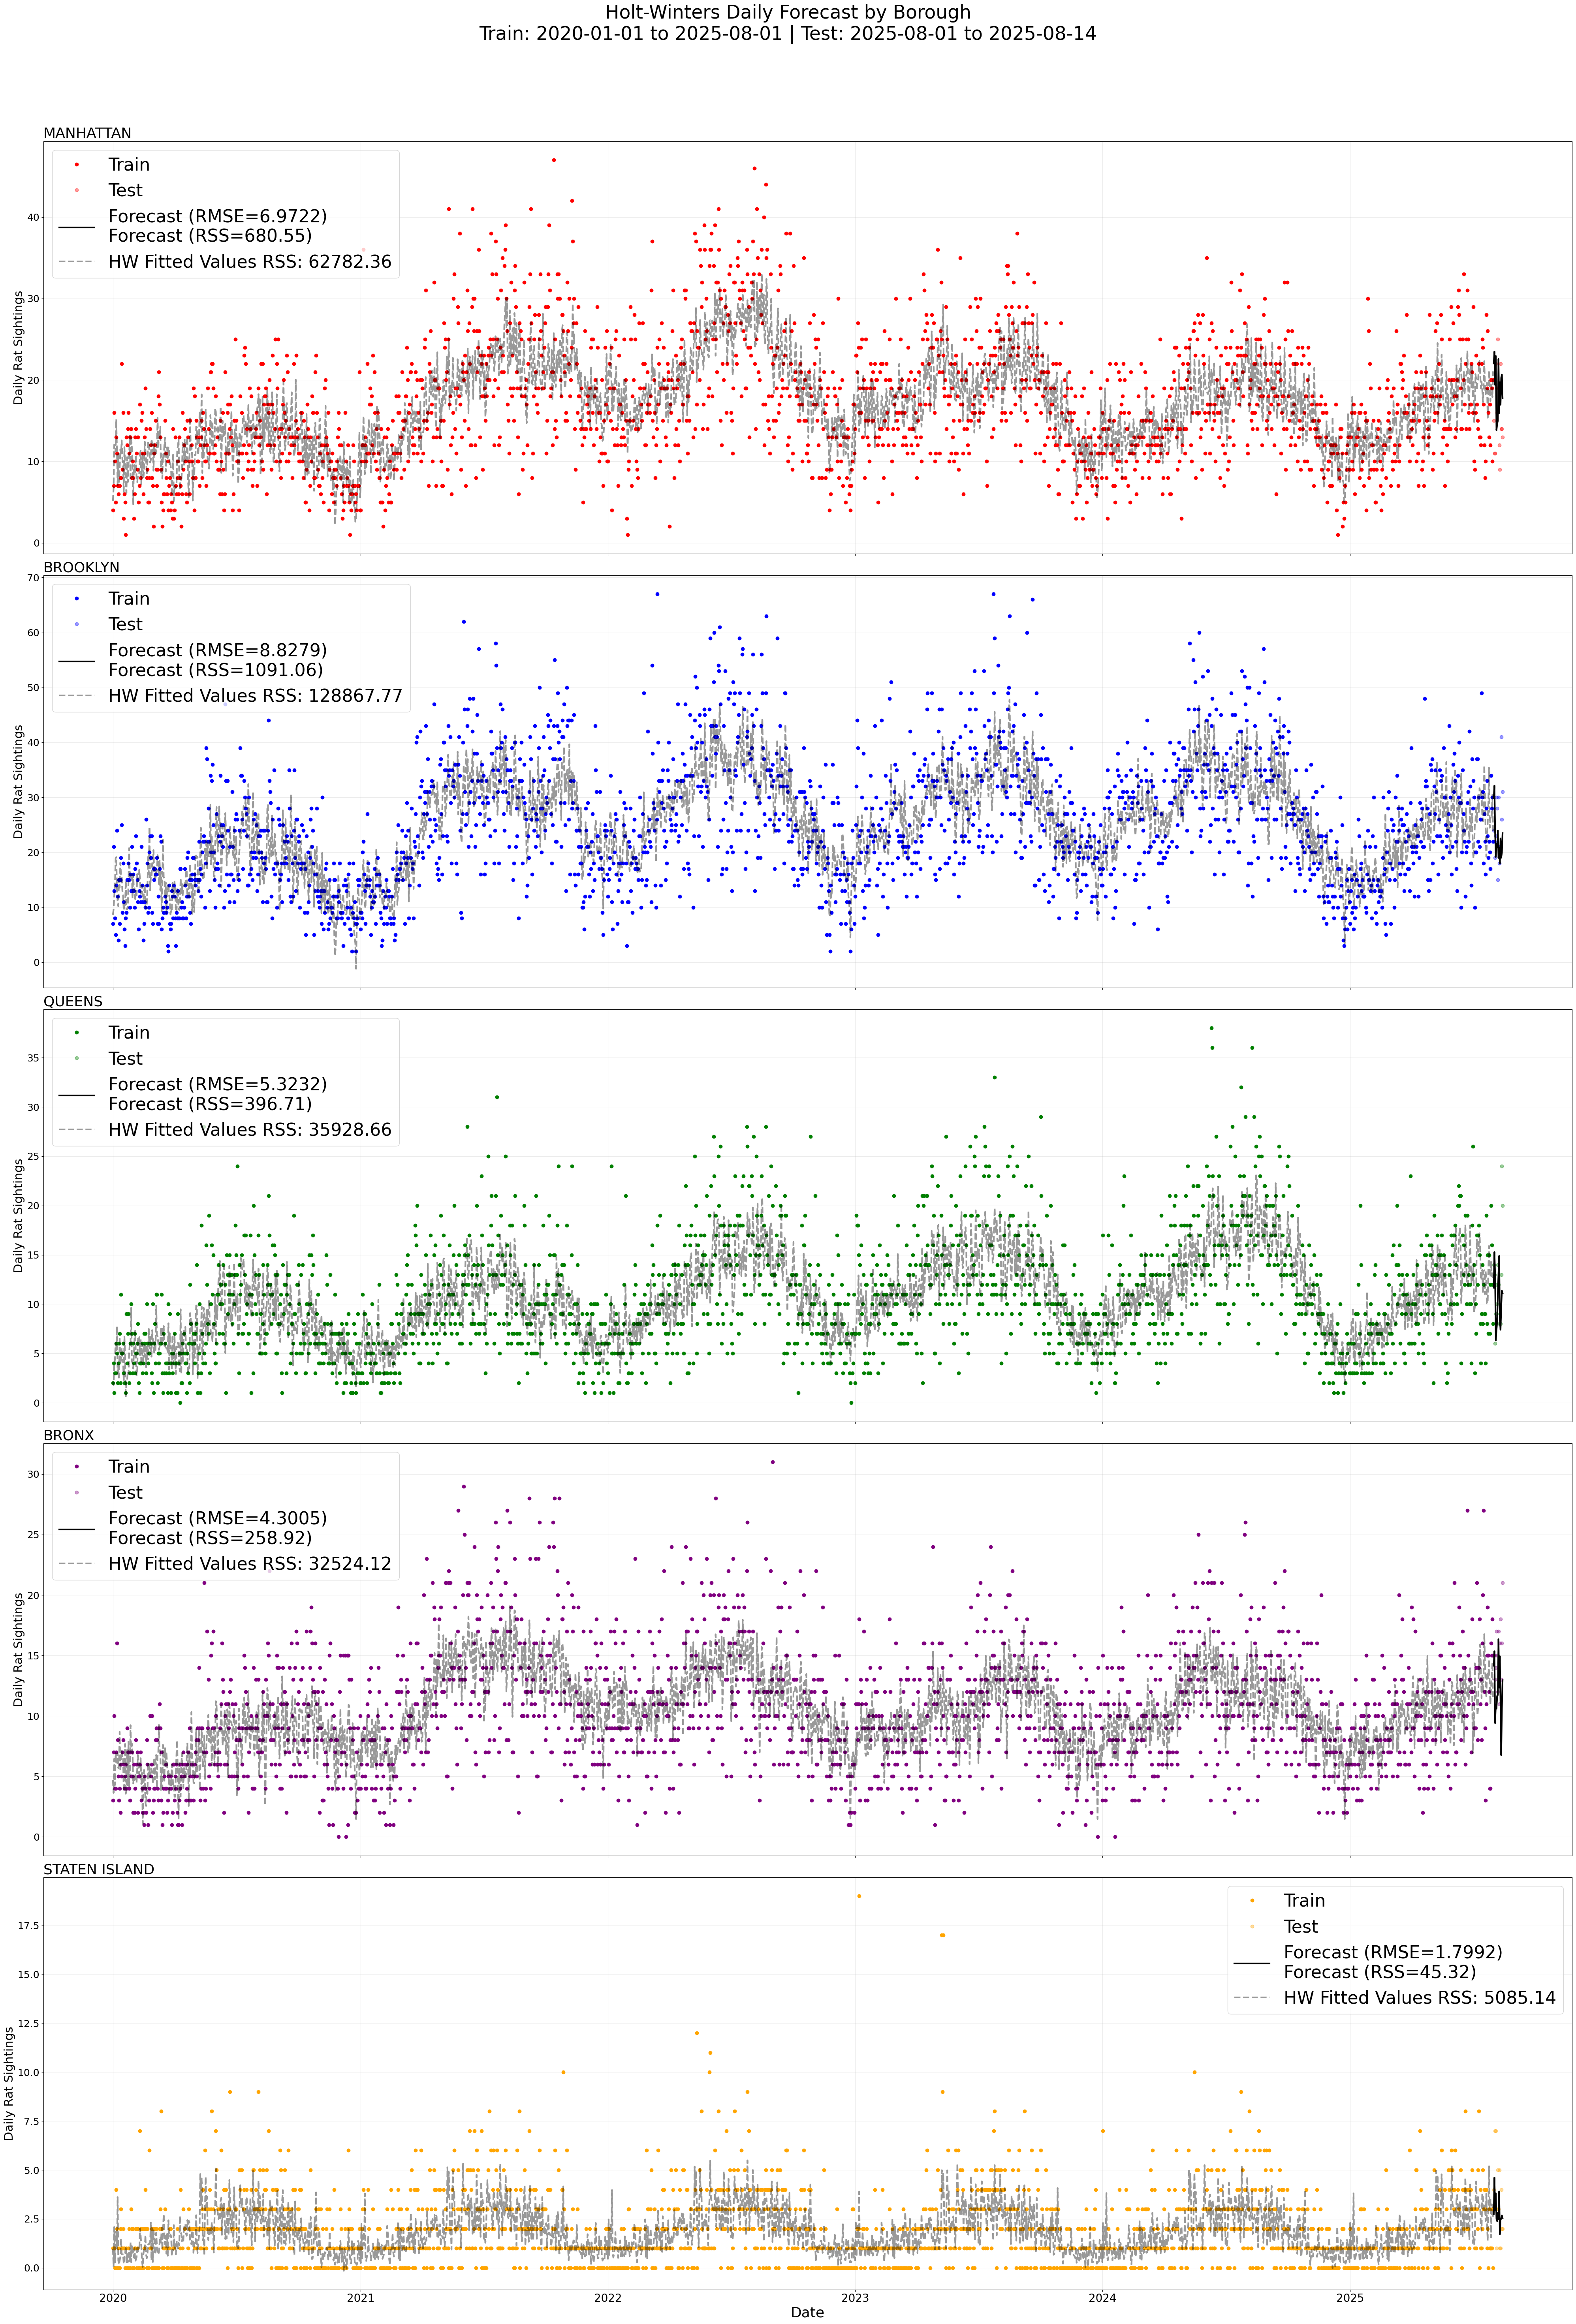

In [434]:
boroughs = ['MANHATTAN', 'BROOKLYN', 'QUEENS', 'BRONX', 'STATEN ISLAND']
colors = {'MANHATTAN': 'r', 'BROOKLYN': 'b','QUEENS': 'g','BRONX': 'purple','STATEN ISLAND': 'orange'}

fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(40, 60),sharex=True)

for ax, borough in zip(axes, boroughs):
    dfb = df[df['borough'] == borough].copy()
    dfb['created_date'] = pd.to_datetime(dfb['created_date'])

    # Fill missing dates with 0 for count
    full_dates = pd.date_range('2020-01-01', last_day, freq='D')
    full_index = pd.MultiIndex.from_product([[borough], full_dates], names=['borough', 'created_date'])

    dfb = dfb.set_index(['borough', 'created_date']).reindex(full_index).fillna({'count': 0}).reset_index()
    dfb['count'] = dfb['count'].astype(int)

    # Split into training and testing data.
    df_train = dfb[dfb['created_date'] < cut_off]
    df_test  = dfb[dfb['created_date'] >= cut_off]

    # Holt-Winters
    model = ExponentialSmoothing(df_train['count'].values, trend='add', seasonal='add', seasonal_periods=365).fit(optimized=True)
    forecast = model.forecast(len(df_test))


    rmse = np.sqrt(np.mean((df_test['count'].values - forecast) ** 2))
    rss =  np.sum((df_test['count'].values - forecast)**2)

    c = colors[borough]

    # Plot 
    ax.plot(df_train['created_date'], df_train['count'], "o", color=c, label='Train')
    ax.plot(df_test['created_date'], df_test['count'], "o", color=c, alpha=0.4, label='Test')
    ax.plot(df_test['created_date'], forecast, linestyle='-', linewidth=3, color="black", label=f'Forecast (RMSE={rmse:.4f})\nForecast (RSS={rss:.2f})')
    ax.plot(df_train['created_date'], model.fittedvalues, linestyle='--', linewidth=3, color='black', label= f'HW Fitted Values RSS: {model.sse:.2f}', alpha=0.4)
    # Title, Legend, Ticks
    ax.set_title(borough, fontsize=26, loc='left')
    ax.set_ylabel("Daily Rat Sightings", fontsize=22)
    ax.tick_params(axis='y', labelsize=18)
    ax.grid(alpha=0.25)
    ax.legend(fontsize=32)
    metrics_table = pd.concat([metrics_table, 
                               pd.DataFrame({'borough': borough,'rmse_hw': [rmse],
                                             'rss_hw': [rss],
                                             'rmse_sa': [np.nan],
                                             'rss_sa': [np.nan]})],
                              ignore_index=True)

# Shared x-axis, title, and display.
axes[-1].set_xlabel("Date", fontsize=26)
axes[-1].tick_params(axis='x', labelsize=20)
fig.suptitle(f"Holt-Winters Daily Forecast by Borough\nTrain: 2020-01-01 to {cut_off} | Test: {cut_off} to {last_day}", fontsize=34)
plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.savefig("../images/holt_winters_daily_borough.png", dpi=300, bbox_inches="tight")
plt.show()

If we compare the daily data for each of these, then the HOLT-WINTERS model performs better in all boroughs EXCEPT Bronx. I wonder why?

In [435]:
def seasonal_average_forecast(data, target_dates, years_back=5, day_window=5):
    df = data.copy()
    df["created_date"] = pd.to_datetime(df["created_date"])
    df["doy"] = df["created_date"].dt.dayofyear
    df["year"] = df["created_date"].dt.year

    forecasts = []
    for target_date in target_dates:
        target_doy = target_date.dayofyear
        target_year = target_date.year
        mask = (
            (df["year"] >= target_year - years_back) &
            (df["year"] < target_year) &
            (np.abs(df["doy"] - target_doy) <= day_window)
        )

        forecasts.append(df.loc[mask, "count"].mean())

    return pd.Series(forecasts, index=target_dates)

In [436]:
rs = pd.read_csv("../scr/data/cleaned_rat_sightings_data/daily_borough_rs.csv")
rs_test = rs[rs['created_date']>=cut_off]
rs_test = rs_test[rs_test['created_date']<=last_day]
rs_train = rs[rs['created_date']<cut_off]
rs_train = rs_train[rs_train['created_date']>='2020-01-01']

rs_test["created_date"] = pd.to_datetime(rs_test["created_date"])
rs_train["created_date"] = pd.to_datetime(rs_train["created_date"])

In [437]:
boroughs = ['MANHATTAN', 'BROOKLYN', 'QUEENS', 'BRONX', 'STATEN ISLAND']
colors = {'MANHATTAN': 'r', 'BROOKLYN': 'b','QUEENS': 'g','BRONX': 'purple','STATEN ISLAND': 'orange'}

full_range = pd.date_range(start="2020-01-01", end=before_cut_off, freq="D")

test_range = pd.date_range(start=cut_off, end = last_day, freq="D")


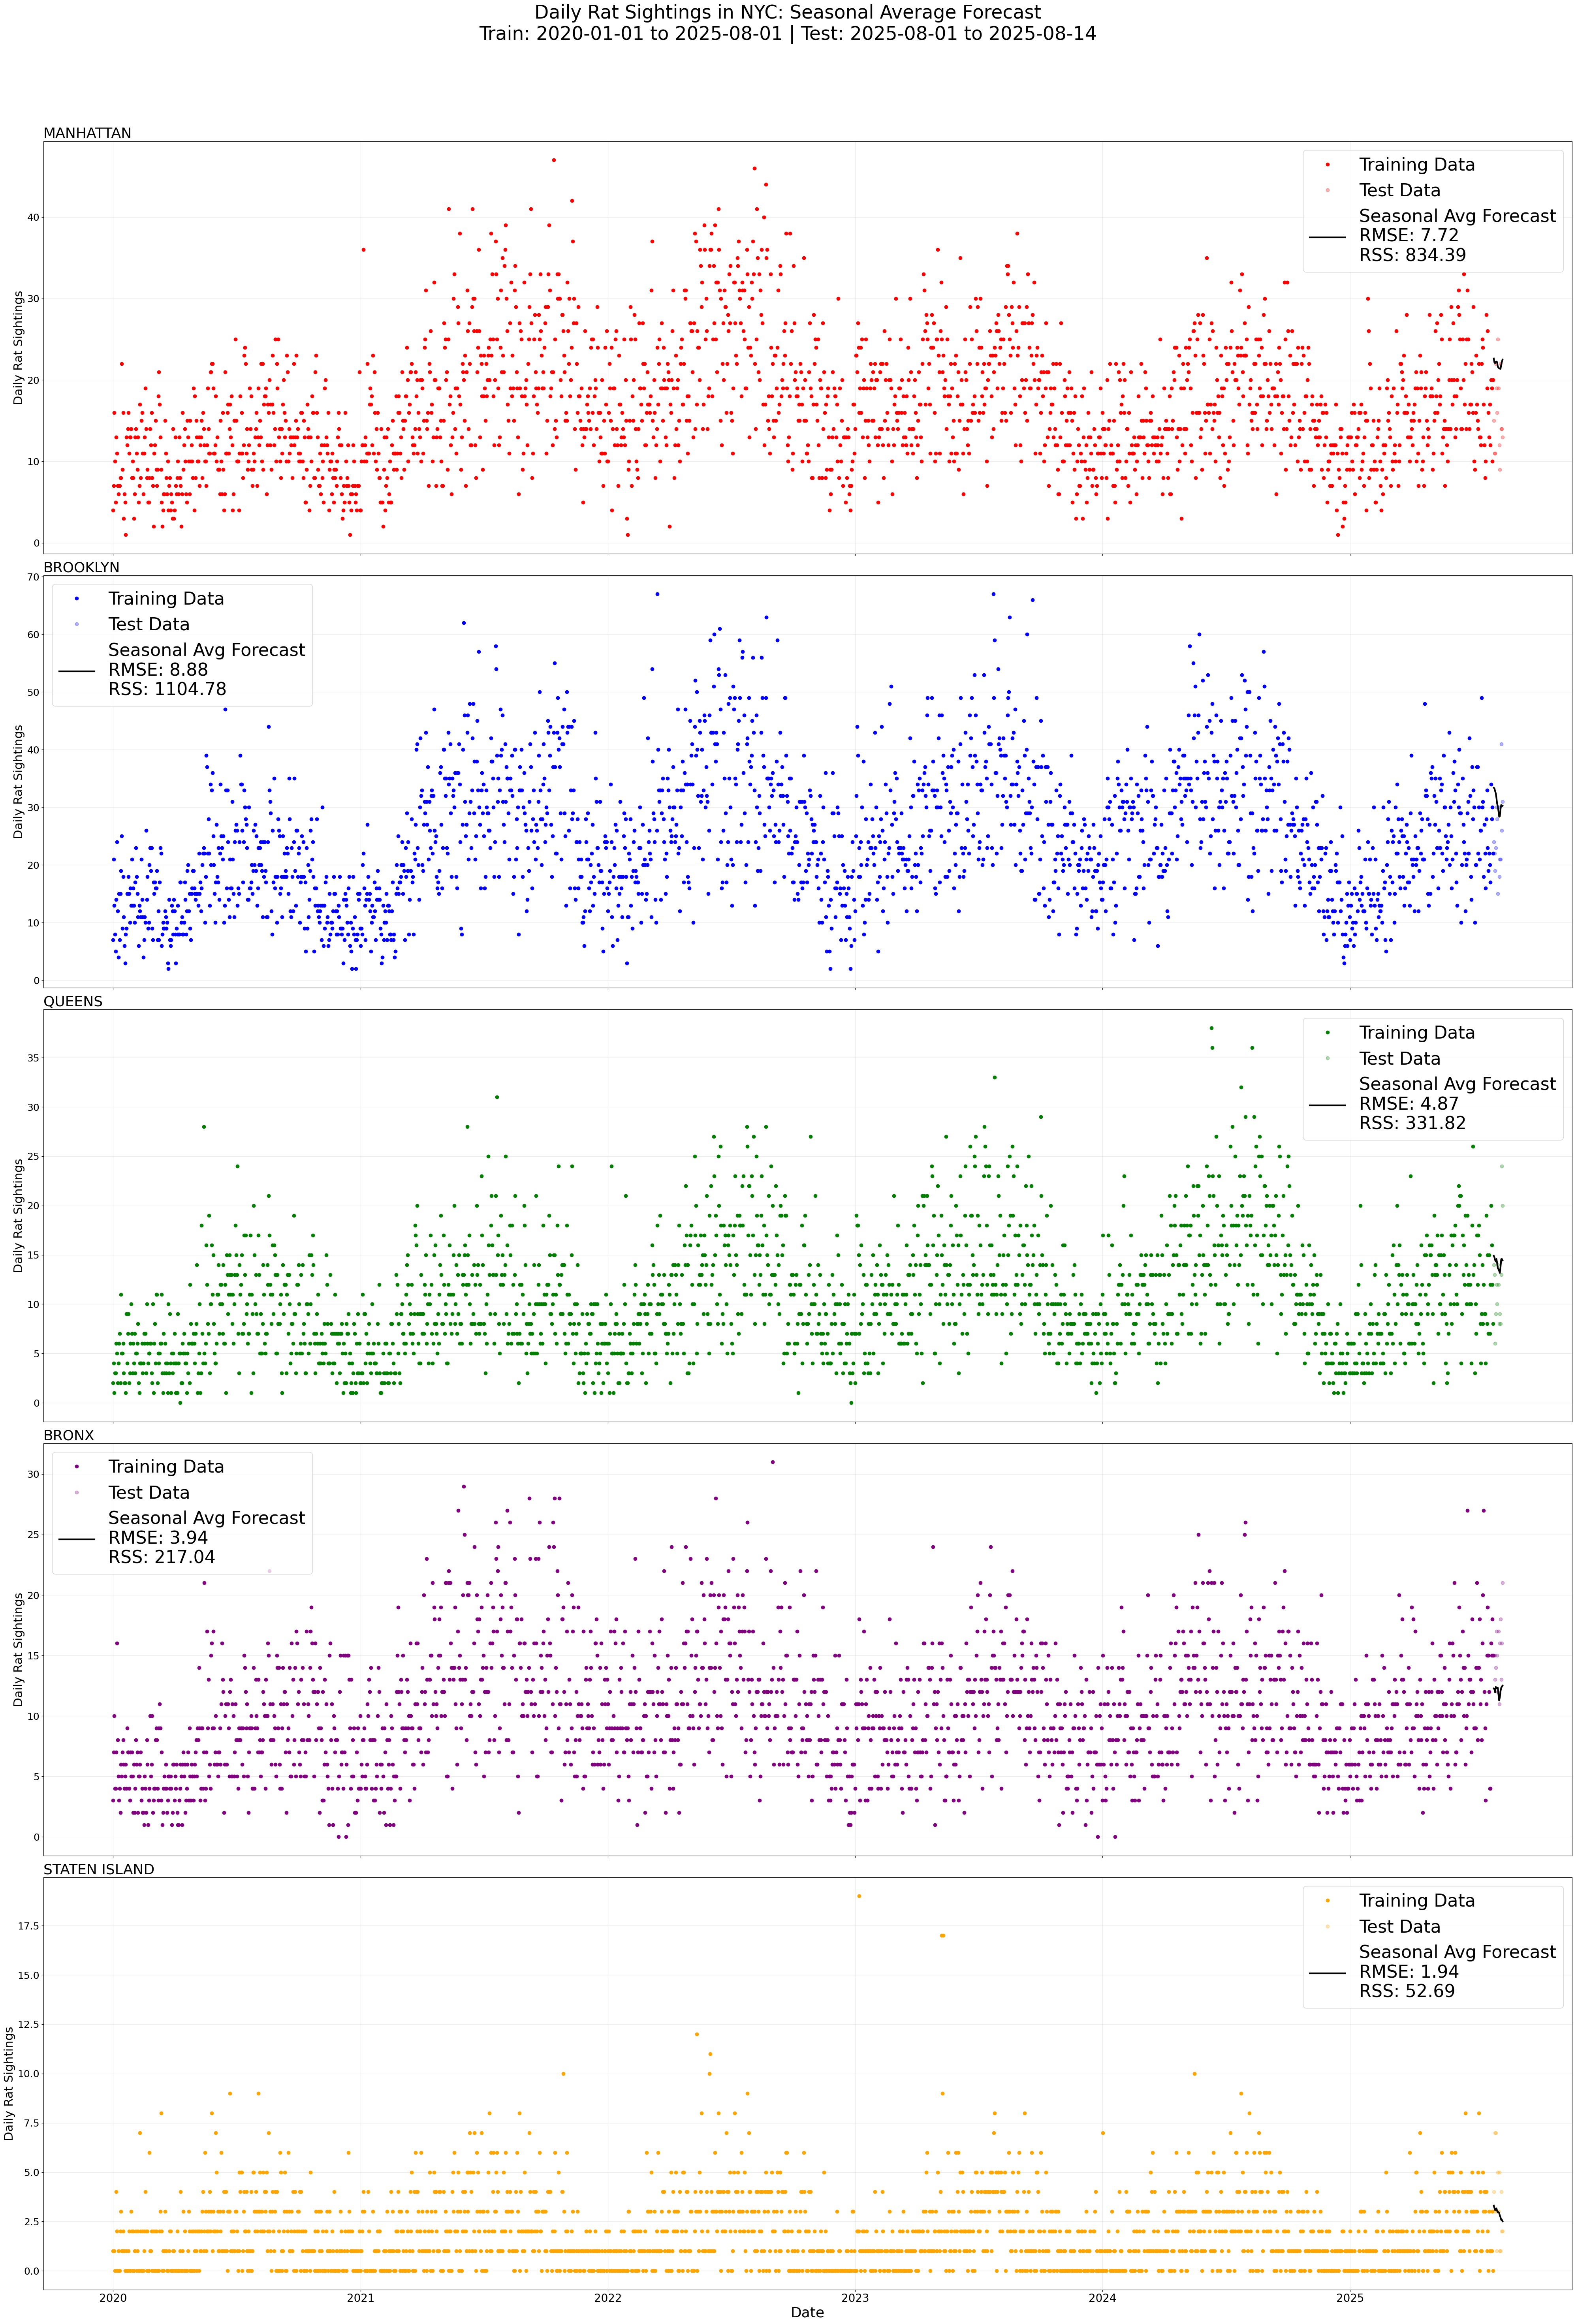

In [438]:
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(40, 60),sharex=True)

for ax, borough in zip(axes, boroughs):
    c = colors[borough]
    borough_data = (rs_train[rs_train["borough"] == borough]
                    .assign(created_date=lambda df: pd.to_datetime(df["created_date"]))
                    .sort_values("created_date").set_index("created_date"))
    # reindex and fill missing days with 0
    borough_data = (borough_data.reindex(full_range)
                    .assign(count=lambda df: df["count"].fillna(0),borough=borough)
                    .rename_axis("created_date")
                    .reset_index())
    
    borough_data_test = (rs_test[rs_test["borough"] == borough]
                    .assign(created_date=lambda df: pd.to_datetime(df["created_date"]))
                    .sort_values("created_date").set_index("created_date"))

    borough_data_test = (borough_data_test.reindex(test_range)
                    .assign(count=lambda df: df["count"].fillna(0),borough=borough)
                    .rename_axis("created_date")
                    .reset_index())


    last_date = rs_train["created_date"].max()
    future_dates = pd.date_range(start=last_date + pd.Timedelta(days=1), periods=len(borough_data_test), freq="D")
    
    # compute seasonal-average forecast
    forecast = seasonal_average_forecast(borough_data,future_dates,years_back=5)

    
    actual_series = borough_data_test.set_index('created_date')['count']
    actual_aligned = actual_series.reindex(forecast.index, fill_value=0)

    rmse = np.sqrt(np.mean((actual_aligned - forecast.values)**2))
    rss = np.sum((actual_aligned - forecast.values)**2)

    # plot training data
    ax.plot(borough_data["created_date"].dt.to_pydatetime(), borough_data["count"], "o", color=c, label="Training Data")
    # plot test data
    borough_data_test["created_date"] = pd.to_datetime(borough_data_test["created_date"])
    ax.plot(borough_data_test["created_date"], borough_data_test["count"], "o", color=c, alpha=0.3, label="Test Data")
    # plot forecast
    ax.plot(forecast.index, forecast.values, color="black", linewidth=3, linestyle = "-", label=f"Seasonal Avg Forecast\nRMSE: {rmse:.2f}\nRSS: {rss:.2f}")

    ax.set_title(borough, fontsize=26, loc='left')
    ax.set_ylabel("Daily Rat Sightings", fontsize=22)
    ax.tick_params(axis='y', labelsize=18)
    ax.grid(alpha=0.25)
    ax.legend(fontsize=32)
    metrics_table = pd.concat([metrics_table, 
                               pd.DataFrame({'borough': borough,'rmse_hw': [np.nan],
                                             'rss_hw': [np.nan],
                                             'rmse_sa': [rmse],
                                             'rss_sa': [rss]})],
                              ignore_index=True)
    
axes[-1].set_xlabel("Date", fontsize=26)
axes[-1].tick_params(axis='x', labelsize=20)
fig.suptitle(f"Daily Rat Sightings in NYC: Seasonal Average Forecast\nTrain: 2020-01-01 to {cut_off} | Test: {cut_off} to {last_day}", fontsize=34)
plt.tight_layout(rect=[0, 0, 1, 0.95])
#plt.savefig("../images/baseline_seasonal_avg_daily_borough.png", dpi=300, bbox_inches="tight")
plt.show()


In [439]:
print(f"For cut off date {cut_off} and final date {last_day}:")
display(metrics_table)

For cut off date 2025-08-01 and final date 2025-08-14:


borough   rmse_hw       rss_hw   rmse_sa       rss_sa
0      MANHATTAN  6.972151   680.552384       NaN          NaN
1       BROOKLYN  8.827944  1091.056224       NaN          NaN
2         QUEENS  5.323226   396.714234       NaN          NaN
3          BRONX  4.300507   258.921096       NaN          NaN
4  STATEN ISLAND  1.799164    45.317861       NaN          NaN
5      MANHATTAN       NaN          NaN  7.720079   834.394711
6       BROOKLYN       NaN          NaN  8.883286  1104.778843
7         QUEENS       NaN          NaN  4.868437   331.823471
8          BRONX       NaN          NaN  3.937346   217.037686
9  STATEN ISLAND       NaN          NaN  1.939942    52.687273

In [440]:
print(f"For cut off date {cut_off} and final date {last_day}:")

df = metrics_table

summary = df.pivot_table(index="borough", values=["rmse_hw", "rmse_sa"], aggfunc="min")

for borough, row in summary.iterrows():
    if pd.isna(row["rmse_hw"]) or pd.isna(row["rmse_sa"]):
        status = "insufficient data"
    elif row["rmse_hw"] < row["rmse_sa"]:
        status = "Holt-Winters beats Seasonal Average"
    else:
        status = "Seasonal Average beats Holt-Winters"

    print(
        f"{borough}: "
        f"RMSE_HW={row['rmse_hw']:.3f}, "
        f"RMSE_SA={row['rmse_sa']:.3f} → {status}"
    )

For cut off date 2025-08-01 and final date 2025-08-14:
BRONX: RMSE_HW=4.301, RMSE_SA=3.937 → Seasonal Average beats Holt-Winters
BROOKLYN: RMSE_HW=8.828, RMSE_SA=8.883 → Holt-Winters beats Seasonal Average
MANHATTAN: RMSE_HW=6.972, RMSE_SA=7.720 → Holt-Winters beats Seasonal Average
QUEENS: RMSE_HW=5.323, RMSE_SA=4.868 → Seasonal Average beats Holt-Winters
STATEN ISLAND: RMSE_HW=1.799, RMSE_SA=1.940 → Holt-Winters beats Seasonal Average


## TODO

Look at the compareHW.ipynb notebook and use write a table of model comparisons here. We want to show that the HW model genuinely does improve on the baseline model at the level of boroughs.